In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm

In [3]:
df = pd.read_csv("F:\Projects & Assignments\day.csv")
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
df.shape

(730, 16)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [6]:
df.duplicated().sum()

0

In [7]:
df.drop(['instant', 'dteday','casual','registered','atemp'], axis=1, inplace=True)

In [8]:
df.shape

(730, 11)

In [9]:
cat_vars = ['season','yr','mnth','holiday','weekday', 'workingday','weathersit']
num_vars = ['temp', 'hum','windspeed','cnt']

In [10]:
df[cat_vars] = df[cat_vars].astype('category')

In [11]:
df.describe()

,temp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000
mean,20.319259,62.765175,12.763620,4508.006849
std,7.506729,14.237589,5.195841,1936.011647
min,2.424346,0.000000,1.500244,22.000000
25%,13.811885,52.000000,9.041650,3169.750000
50%,20.465826,62.625000,12.125325,4548.500000
75%,26.880615,72.989575,15.625589,5966.000000
max,35.328347,97.250000,34.000021,8714.000000


In [12]:
df.describe(include=['category'])

,season,yr,mnth,holiday,weekday,workingday,weathersit
count,730,730,730,730,730,730,730
unique,4,2,12,2,7,2,3
top,3,0,1,0,1,1,1
freq,188,365,62,709,105,504,463


In [13]:
df['season'] = df['season'].map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})

df['weekday'] = df['weekday'].map({0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'})

df['mnth'] = df['mnth'].map({1:'jan', 2:'feb', 3:'mar', 4:'apr', 5: 'may', 6: 'jun', 7: 'jul', 8: 'aug', 9: 'sep', 10: 'oct',
                             11: 'nov', 12:'dec'})
df['weathersit'] = df['weathersit'].map({1: 'Clear_FewClouds', 2: 'Mist_Cloudy', 3: 'LightSnow_LightRain', 4: 'HeavyRain_IcePallets'})

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      730 non-null    category
 1   yr          730 non-null    category
 2   mnth        730 non-null    category
 3   holiday     730 non-null    category
 4   weekday     730 non-null    category
 5   workingday  730 non-null    category
 6   weathersit  730 non-null    category
 7   temp        730 non-null    float64 
 8   hum         730 non-null    float64 
 9   windspeed   730 non-null    float64 
 10  cnt         730 non-null    int64   
dtypes: category(7), float64(3), int64(1)
memory usage: 29.4 KB


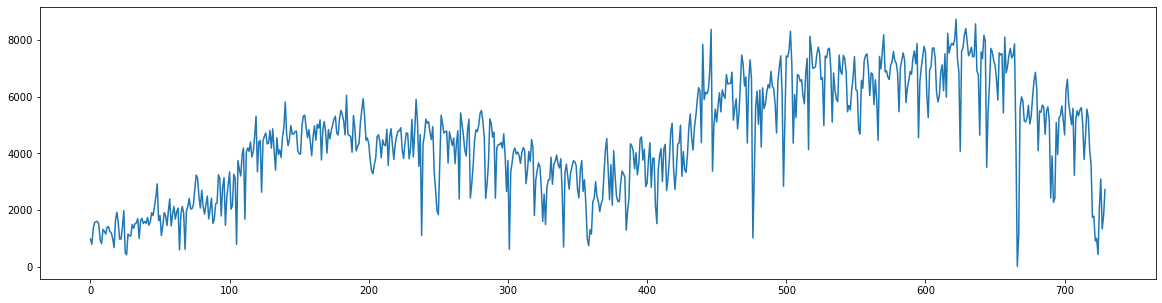

In [15]:
plt.figure(figsize=(20,5))
plt.plot(df.cnt)
plt.show()

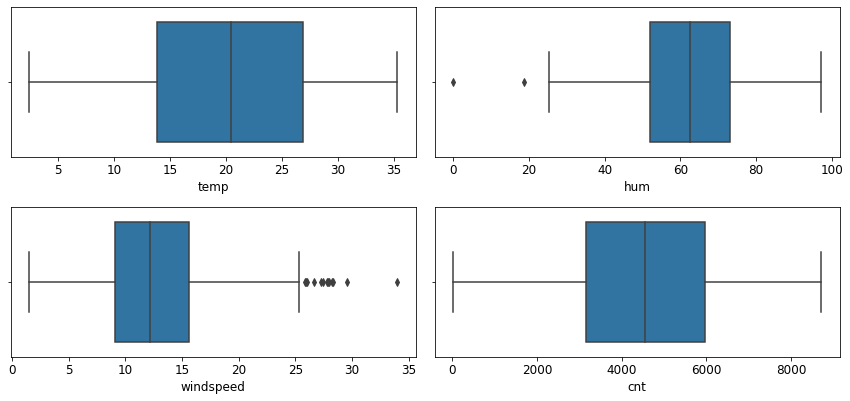

In [16]:
var = df.select_dtypes(exclude = 'category').columns
col = 2
row = len(var)//col+1

plt.figure(figsize=(12,8))
plt.rc('font', size=12)
for i in list(enumerate(var)):
    plt.subplot(row, col, i[0]+1)
    sns.boxplot(df[i[1]])    
plt.tight_layout()   
plt.show()

In [17]:
def percentage_outlier(x):
    iqr = df[x].quantile(0.75)-df[x].quantile(0.25)
    HL = df[x].quantile(0.75)+iqr*1.5
    LL = df[x].quantile(0.25)-iqr*1.5
    per_outlier = ((df[x]<LL).sum()+(df[x]>HL).sum())/len(df[x])*100
    per_outlier = round(per_outlier,2)
    return(per_outlier)

print('Percentage of outlier (hum): ', percentage_outlier('hum'))
print('Percentage of outlier (windspeed): ', percentage_outlier('windspeed'))

Percentage of outlier (hum):  0.27
Percentage of outlier (windspeed):  1.78


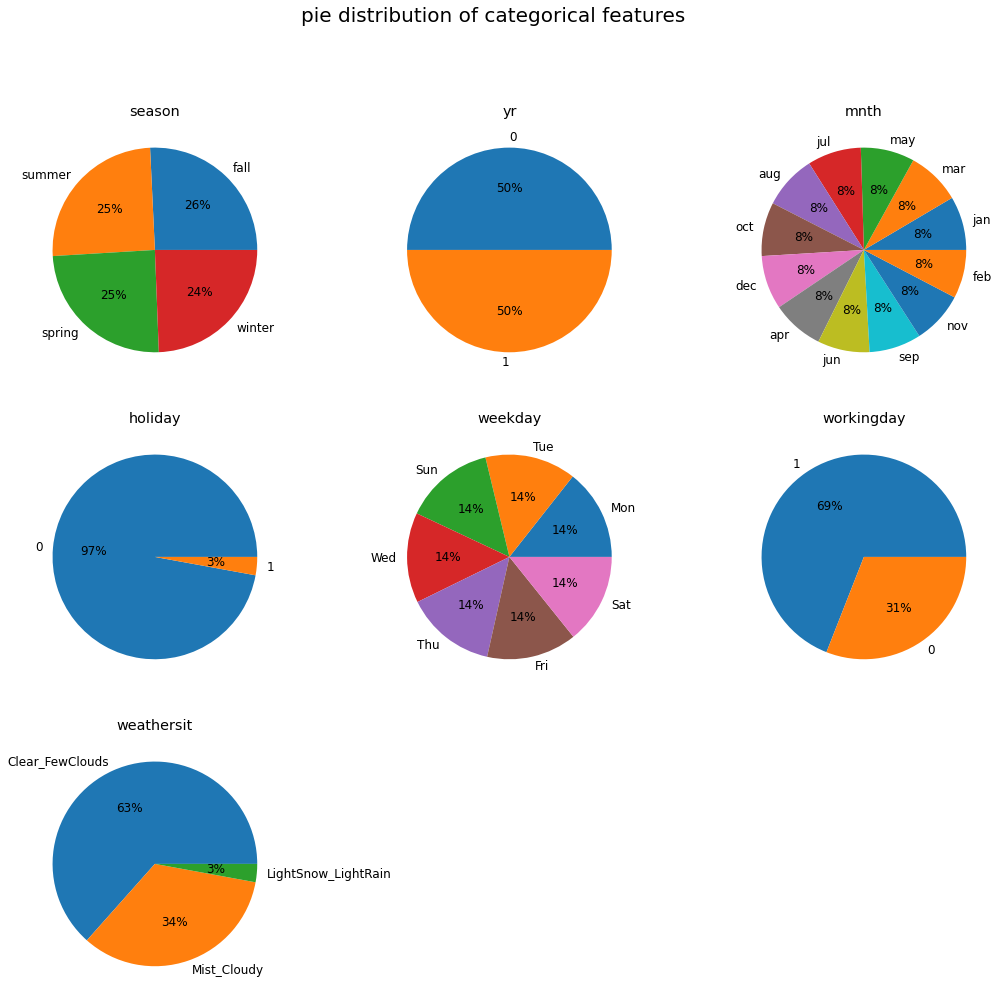

In [18]:
df_piplot=df.select_dtypes(include='category')
plt.figure(figsize=(18,16))
plt.suptitle('pie distribution of categorical features', fontsize=20)
for i in range(1,df_piplot.shape[1]+1):
    plt.subplot(3,3,i)
    f=plt.gca()
    f.set_title(df_piplot.columns.values[i-1])
    values=df_piplot.iloc[:,i-1].value_counts(normalize=True).values
    index=df_piplot.iloc[:,i-1].value_counts(normalize=True).index
    plt.pie(values,labels=index,autopct='%1.0f%%')
plt.show()

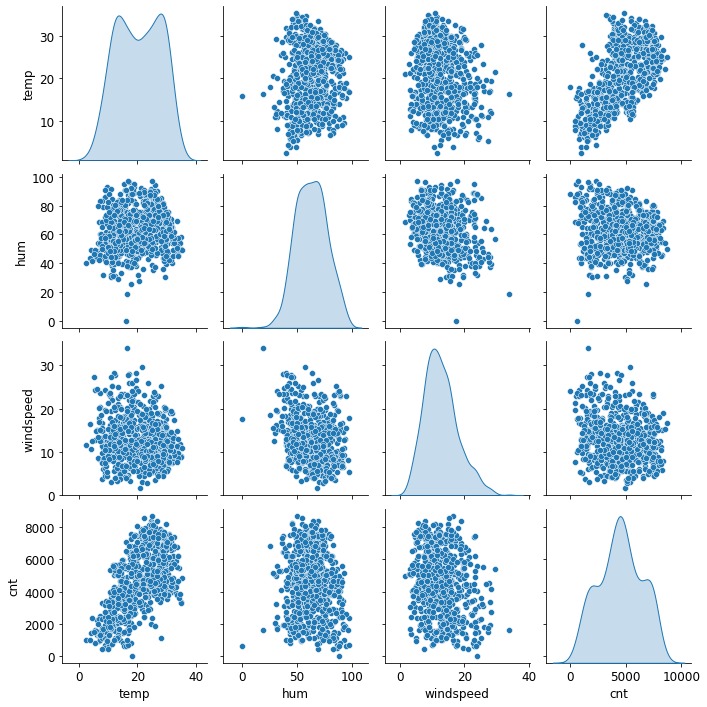

In [19]:
sns.pairplot(df.select_dtypes(['int64','float64']), diag_kind='kde')
plt.show()

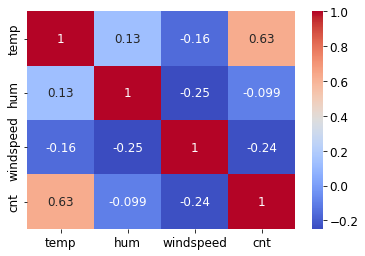

In [20]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

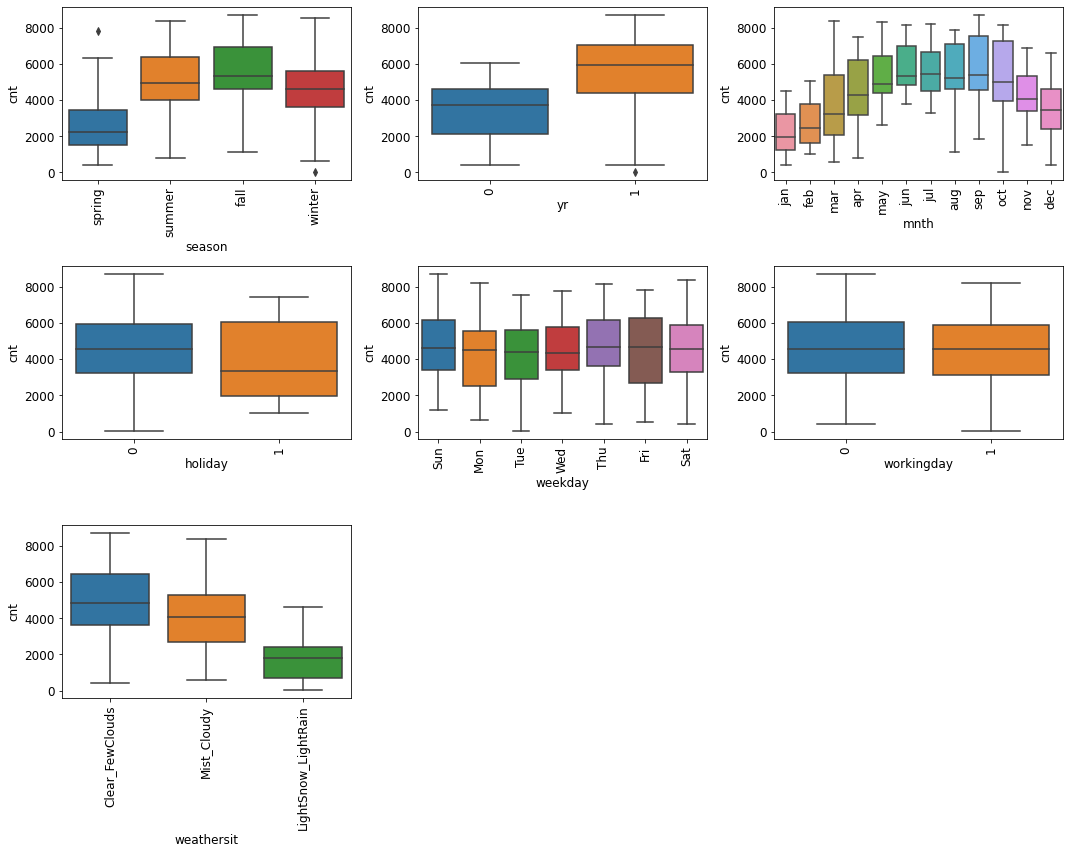

In [21]:
col = 3
row = len(cat_vars)//col+1

plt.figure(figsize=(15,12))
for i in list(enumerate(cat_vars)):
    plt.subplot(row,col,i[0]+1)
    sns.boxplot(x = i[1], y = 'cnt', data = df)
    plt.xticks(rotation = 90)
plt.tight_layout(pad = 1)    
plt.show()

In [22]:
dummy_vars = pd.get_dummies(df[['season','weekday','mnth','weathersit']],drop_first=True)

df = pd.concat([df,dummy_vars], axis = 1)

df.drop(['season','weekday','mnth','weathersit'], axis=1, inplace=True)

df.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_summer,season_fall,season_winter,...,mnth_may,mnth_jun,mnth_jul,mnth_aug,mnth_sep,mnth_oct,mnth_nov,mnth_dec,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
0,0,0,1,14.110847,80.5833,10.749882,985,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,14.902598,69.6087,16.652113,801,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,1,8.050924,43.7273,16.636703,1349,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,8.200000,59.0435,10.739832,1562,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,9.305237,43.6957,12.522300,1600,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
df.shape

(730, 29)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   yr                              730 non-null    category
 1   holiday                         730 non-null    category
 2   workingday                      730 non-null    category
 3   temp                            730 non-null    float64 
 4   hum                             730 non-null    float64 
 5   windspeed                       730 non-null    float64 
 6   cnt                             730 non-null    int64   
 7   season_summer                   730 non-null    uint8   
 8   season_fall                     730 non-null    uint8   
 9   season_winter                   730 non-null    uint8   
 10  weekday_Mon                     730 non-null    uint8   
 11  weekday_Tue                     730 non-null    uint8   
 12  weekday_Wed           

In [26]:
df[['yr','holiday','workingday']]= df[['yr','holiday','workingday']].astype('uint8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   yr                              730 non-null    uint8  
 1   holiday                         730 non-null    uint8  
 2   workingday                      730 non-null    uint8  
 3   temp                            730 non-null    float64
 4   hum                             730 non-null    float64
 5   windspeed                       730 non-null    float64
 6   cnt                             730 non-null    int64  
 7   season_summer                   730 non-null    uint8  
 8   season_fall                     730 non-null    uint8  
 9   season_winter                   730 non-null    uint8  
 10  weekday_Mon                     730 non-null    uint8  
 11  weekday_Tue                     730 non-null    uint8  
 12  weekday_Wed                     730 

In [28]:
df[['yr','holiday','workingday']]= df[['yr','holiday','workingday']].astype('uint8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   yr                              730 non-null    uint8  
 1   holiday                         730 non-null    uint8  
 2   workingday                      730 non-null    uint8  
 3   temp                            730 non-null    float64
 4   hum                             730 non-null    float64
 5   windspeed                       730 non-null    float64
 6   cnt                             730 non-null    int64  
 7   season_summer                   730 non-null    uint8  
 8   season_fall                     730 non-null    uint8  
 9   season_winter                   730 non-null    uint8  
 10  weekday_Mon                     730 non-null    uint8  
 11  weekday_Tue                     730 non-null    uint8  
 12  weekday_Wed                     730 

In [29]:
df_train, df_test = train_test_split(df, train_size = 0.7, random_state = 10 )
print(df_train.shape)
print(df_test.shape)

(510, 29)
(220, 29)


In [30]:
scaler = MinMaxScaler()
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_summer,season_fall,season_winter,...,mnth_may,mnth_jun,mnth_jul,mnth_aug,mnth_sep,mnth_oct,mnth_nov,mnth_dec,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
72,0,0,1,0.298094,0.393891,0.236118,0.194978,0,0,0,...,0,0,0,0,0,0,0,0,0,0
510,1,0,0,0.778657,0.694105,0.364071,0.737052,1,0,0,...,1,0,0,0,0,0,0,0,0,0
700,1,0,1,0.327249,0.809877,0.210252,0.509236,0,0,1,...,0,0,0,0,0,0,0,1,1,0
264,0,0,0,0.694699,0.910249,0.217975,0.526862,0,1,0,...,0,0,0,0,1,0,0,0,1,0
577,1,0,1,0.811368,0.624004,0.244886,0.863093,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [31]:
df_test.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_summer,season_fall,season_winter,...,mnth_may,mnth_jun,mnth_jul,mnth_aug,mnth_sep,mnth_oct,mnth_nov,mnth_dec,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
566,1,0,0,24.429153,86.5417,14.291100,4459,0,1,0,...,0,0,1,0,0,0,0,0,0,1
374,1,0,1,12.656536,64.6522,12.565984,3598,0,0,0,...,0,0,0,0,0,0,0,0,0,0
181,0,0,0,29.622500,39.6250,6.874736,5362,0,1,0,...,0,0,1,0,0,0,0,0,0,0
529,1,0,1,26.581653,56.9583,17.000111,7363,1,0,0,...,0,1,0,0,0,0,0,0,0,0
233,0,0,1,28.358347,47.0000,18.542250,4758,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [32]:
df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_summer,season_fall,season_winter,...,mnth_may,mnth_jun,mnth_jul,mnth_aug,mnth_sep,mnth_oct,mnth_nov,mnth_dec,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
566,1,0,0,0.652175,0.863516,0.393568,0.486297,0,1,0,...,0,0,1,0,0,0,0,0,0,1
374,1,0,1,0.276477,0.584521,0.340487,0.382349,0,0,0,...,0,0,0,0,0,0,0,0,0,0
181,0,0,0,0.817910,0.265533,0.165370,0.595316,0,1,0,...,0,0,1,0,0,0,0,0,0,0
529,1,0,1,0.720868,0.486457,0.476922,0.836895,1,0,0,...,0,1,0,0,0,0,0,0,0,0
233,0,0,1,0.777567,0.359532,0.524373,0.522395,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [33]:
y_train = df_train.pop('cnt')
X_train = df_train
X_train.head()

,yr,holiday,workingday,temp,hum,windspeed,season_summer,season_fall,season_winter,weekday_Mon,...,mnth_may,mnth_jun,mnth_jul,mnth_aug,mnth_sep,mnth_oct,mnth_nov,mnth_dec,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
72,0,0,1,0.298094,0.393891,0.236118,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
510,1,0,0,0.778657,0.694105,0.364071,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
700,1,0,1,0.327249,0.809877,0.210252,0,0,1,1,...,0,0,0,0,0,0,0,1,1,0
264,0,0,0,0.694699,0.910249,0.217975,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
577,1,0,1,0.811368,0.624004,0.244886,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [34]:
y_test = df_test.pop('cnt')
X_test = df_test

X_test.head()

,yr,holiday,workingday,temp,hum,windspeed,season_summer,season_fall,season_winter,weekday_Mon,...,mnth_may,mnth_jun,mnth_jul,mnth_aug,mnth_sep,mnth_oct,mnth_nov,mnth_dec,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
566,1,0,0,0.652175,0.863516,0.393568,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
374,1,0,1,0.276477,0.584521,0.340487,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
181,0,0,0,0.817910,0.265533,0.165370,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
529,1,0,1,0.720868,0.486457,0.476922,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
233,0,0,1,0.777567,0.359532,0.524373,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [35]:
X_train.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'season_summer', 'season_fall', 'season_winter', 'weekday_Mon',
       'weekday_Tue', 'weekday_Wed', 'weekday_Thu', 'weekday_Fri',
       'weekday_Sat', 'mnth_feb', 'mnth_mar', 'mnth_apr', 'mnth_may',
       'mnth_jun', 'mnth_jul', 'mnth_aug', 'mnth_sep', 'mnth_oct', 'mnth_nov',
       'mnth_dec', 'weathersit_Mist_Cloudy', 'weathersit_LightSnow_LightRain'],
      dtype='object')

In [37]:
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'temp', 'hum', 'windspeed', 'season_summer',
       'season_fall', 'season_winter', 'mnth_mar', 'mnth_may', 'mnth_aug',
       'mnth_sep', 'mnth_oct', 'weathersit_Mist_Cloudy',
       'weathersit_LightSnow_LightRain'],
      dtype='object')

In [38]:
X_train_rfe = X_train[col]

In [39]:
 def sm_linearmodel(X_train_sm):
    X_train_sm = sm.add_constant(X_train_sm)

    lm = sm.OLS(y_train,X_train_sm).fit()
    return lm

In [40]:
def vif_calc(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif = vif.sort_values(by='VIF', ascending = False)
    return vif

In [41]:
lm_1 = sm_linearmodel(X_train_rfe)
print(lm_1.summary())
print(vif_calc(X_train_rfe))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     180.5
Date:                Wed, 01 Nov 2023   Prob (F-statistic):          2.39e-189
Time:                        20:02:51   Log-Likelihood:                 489.38
No. Observations:                 510   AIC:                            -946.8
Df Residuals:                     494   BIC:                            -879.0
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [42]:
pvalue = lm_1.pvalues
while(max(pvalue)>0.05):
    maxp_var = pvalue[pvalue == pvalue.max()].index
    print('Removed variable:' , maxp_var[0], '    P value: ', round(max(pvalue),3))
    
    X_train_rfe = X_train_rfe.drop(maxp_var, axis = 1)
    lm_1 = sm_linearmodel(X_train_rfe)
    pvalue = lm_1.pvalues

Removed variable: mnth_may     P value:  0.054
Removed variable: mnth_aug     P value:  0.056


In [43]:
print(lm_1.summary())

print(vif_calc(X_train_rfe))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     205.5
Date:                Wed, 01 Nov 2023   Prob (F-statistic):          4.51e-190
Time:                        20:03:25   Log-Likelihood:                 485.58
No. Observations:                 510   AIC:                            -943.2
Df Residuals:                     496   BIC:                            -883.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [44]:
X_train_new = X_train_rfe.drop(['hum'],axis = 1)

lm_2 = sm_linearmodel(X_train_new)
print(lm_2.summary())
print(vif_calc(X_train_new))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     211.3
Date:                Wed, 01 Nov 2023   Prob (F-statistic):          2.17e-186
Time:                        20:03:51   Log-Likelihood:                 474.04
No. Observations:                 510   AIC:                            -922.1
Df Residuals:                     497   BIC:                            -867.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [45]:
X_train_new = X_train_new.drop(['season_fall'],axis = 1)
lm_3 = sm_linearmodel(X_train_new)
print(lm_3.summary())
print(vif_calc(X_train_new))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     217.0
Date:                Wed, 01 Nov 2023   Prob (F-statistic):          5.89e-182
Time:                        20:04:12   Log-Likelihood:                 460.73
No. Observations:                 510   AIC:                            -897.5
Df Residuals:                     498   BIC:                            -846.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [46]:
X_train_new = X_train_new.drop(['mnth_mar'],axis = 1)
lm_4 = sm_linearmodel(X_train_new)
print(lm_4.summary())
print(vif_calc(X_train_new))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     235.9
Date:                Wed, 01 Nov 2023   Prob (F-statistic):          5.83e-182
Time:                        20:04:26   Log-Likelihood:                 457.90
No. Observations:                 510   AIC:                            -893.8
Df Residuals:                     499   BIC:                            -847.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [47]:
X_train_new = X_train_new.drop(['mnth_oct'],axis = 1)
lm_5 = sm_linearmodel(X_train_new)
print(lm_5.summary())
print(vif_calc(X_train_new))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     256.8
Date:                Wed, 01 Nov 2023   Prob (F-statistic):          3.57e-181
Time:                        20:04:44   Log-Likelihood:                 453.17
No. Observations:                 510   AIC:                            -886.3
Df Residuals:                     500   BIC:                            -844.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [48]:
lm_final = lm_5
var_final = list(lm_final.params.index)
var_final.remove('const')
print('Final Selected Variables:', var_final)
print('\033[1m{:10s}\033[0m'.format('\nCoefficent for the variables are:'))
print(round(lm_final.params,3))

Final Selected Variables: ['yr', 'holiday', 'temp', 'windspeed', 'season_summer', 'season_winter', 'mnth_sep', 'weathersit_Mist_Cloudy', 'weathersit_LightSnow_LightRain']

Coefficent for the variables are:
const                             0.097
yr                                0.256
holiday                          -0.097
temp                              0.552
windspeed                        -0.135
season_summer                     0.092
season_winter                     0.143
mnth_sep                          0.093
weathersit_Mist_Cloudy           -0.085
weathersit_LightSnow_LightRain   -0.264
dtype: float64


In [49]:
X_train_res = X_train[var_final]

In [50]:
X_train_res = sm.add_constant(X_train_res)
y_train_pred = lm_final.predict(X_train_res)

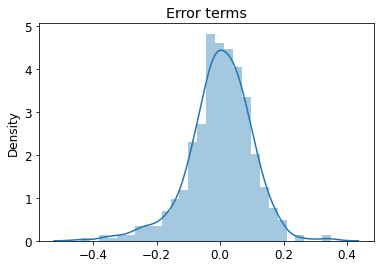

In [51]:
res = y_train - y_train_pred
sns.distplot(res)
plt.title('Error terms')
plt.show()

Text(0, 0.5, 'Residual')

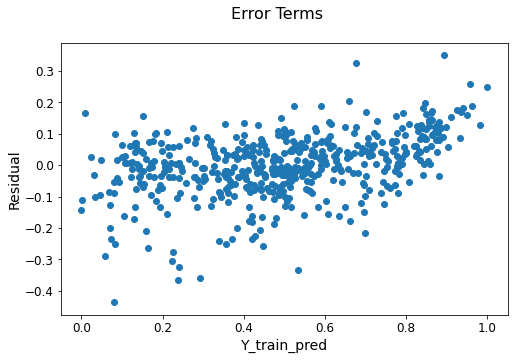

In [52]:
c = [i for i in range(1,len(y_train)+1,1)]
fig = plt.figure(figsize=(8,5))
plt.scatter(y_train,res)
fig.suptitle('Error Terms', fontsize=16)
plt.xlabel('Y_train_pred', fontsize=14)
plt.ylabel('Residual', fontsize=14)  

In [53]:
df_test.head()

,yr,holiday,workingday,temp,hum,windspeed,season_summer,season_fall,season_winter,weekday_Mon,...,mnth_may,mnth_jun,mnth_jul,mnth_aug,mnth_sep,mnth_oct,mnth_nov,mnth_dec,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
566,1,0,0,0.652175,0.863516,0.393568,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
374,1,0,1,0.276477,0.584521,0.340487,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
181,0,0,0,0.817910,0.265533,0.165370,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
529,1,0,1,0.720868,0.486457,0.476922,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
233,0,0,1,0.777567,0.359532,0.524373,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [54]:
X_test_sm = X_test[var_final]
X_test_sm.head()

,yr,holiday,temp,windspeed,season_summer,season_winter,mnth_sep,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
566,1,0,0.652175,0.393568,0,0,0,0,1
374,1,0,0.276477,0.340487,0,0,0,0,0
181,0,0,0.817910,0.165370,0,0,0,0,0
529,1,0,0.720868,0.476922,1,0,0,0,0
233,0,0,0.777567,0.524373,0,0,0,0,0


In [57]:
X_test_sm = sm.add_constant(X_test_sm)
X_test_sm.head()

,const,yr,holiday,temp,windspeed,season_summer,season_winter,mnth_sep,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
566,1.0,1,0,0.652175,0.393568,0,0,0,0,1
374,1.0,1,0,0.276477,0.340487,0,0,0,0,0
181,1.0,0,0,0.817910,0.165370,0,0,0,0,0
529,1.0,1,0,0.720868,0.476922,1,0,0,0,0
233,1.0,0,0,0.777567,0.524373,0,0,0,0,0


In [58]:
y_test_pred = lm_final.predict(X_test_sm)

In [59]:
r2_test = r2_score(y_true = y_test, y_pred = y_test_pred)
print('R-Squared for Test dataset: ', round(r2_test,3))

R-Squared for Test dataset:  0.815


In [60]:
N= len(X_test)
p =len(var_final)
r2_test_adj = round((1-((1-r2_test)*(N-1)/(N-p-1))),3)
print('Adj. R-Squared for Test dataset: ', round(r2_test_adj,3))

Adj. R-Squared for Test dataset:  0.807


In [61]:
mse = mean_squared_error(y_test, y_test_pred)
print('Mean_Squared_Error :' ,round(mse,4))

Mean_Squared_Error : 0.0096


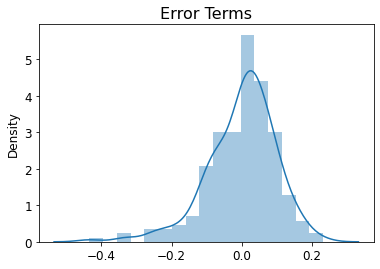

In [62]:
res_test = y_test - y_test_pred
plt.title('Error Terms', fontsize=16) 
sns.distplot(res_test)
plt.show()

Text(0, 0.5, 'Residual')

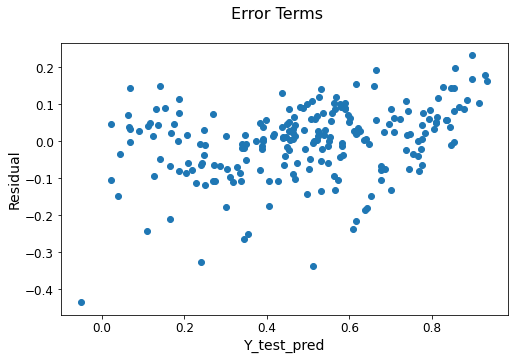

In [63]:
c = [i for i in range(1,len(y_test)+1,1)]
fig = plt.figure(figsize=(8,5))
plt.scatter(y_test,res_test)
fig.suptitle('Error Terms', fontsize=16)
plt.xlabel('Y_test_pred', fontsize=14)
plt.ylabel('Residual', fontsize=14)   

Text(0, 0.5, 'y_test_pred')

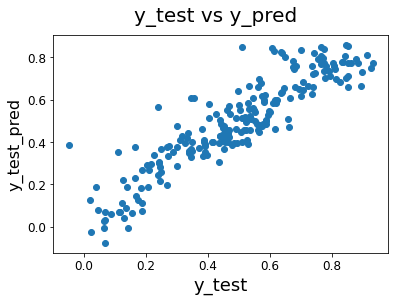

In [64]:
fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)
plt.xlabel('y_test', fontsize = 18)
plt.ylabel('y_test_pred', fontsize = 16) 

In [65]:
print('R- Sqaured train: ', round(lm_final.rsquared,2), '  Adj. R-Squared train:', round(lm_final.rsquared_adj,3) )
print('R- Sqaured test : ', round(r2_test,2), '  Adj. R-Squared test :', round(r2_test_adj,3))
print('\033[1m{:10s}\033[0m'.format('\nCoefficent for the variables are:'))
print(round(lm_final.params,3))

R- Sqaured train:  0.82   Adj. R-Squared train: 0.819
R- Sqaured test :  0.81   Adj. R-Squared test : 0.807

Coefficent for the variables are:
const                             0.097
yr                                0.256
holiday                          -0.097
temp                              0.552
windspeed                        -0.135
season_summer                     0.092
season_winter                     0.143
mnth_sep                          0.093
weathersit_Mist_Cloudy           -0.085
weathersit_LightSnow_LightRain   -0.264
dtype: float64
